In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from library.Data_Preprocessing import Balance_Ratio
from library.Imbalance_Sampling import label_divide, under_over, over_under
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, all_optuna, optuna_history

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### Balance Cascade

In [2]:
# train & test of balance cascade (scheme 1 & 2)
class BalanceCascade:
    
    def __init__(self, base_clf = 'LightGBM', num_iter = 10, over_method = None, under_method = 'NM', 
                 over_num = 5, verbose = True):
        self.classifier = base_clf
        self.num_iter = num_iter
        self.over_method = over_method
        self.under_method = under_method
        self.over_num = over_num if over_method else 1
        self.verbose = verbose
        if over_method not in ['ADASYN', 'SMOTEN', None]:
            raise Exception(f'{over_method} is not implemented !') 
        if under_method not in ['NM', 'random']:
            raise Exception(f'{under_method} is not implemented !') 
        if base_clf not in ['LightGBM', 'RandomForest']:
            raise Exception(f'{base_clf} is not implemented !') 
    
    
    def training(self, train_data, clf_config):
        origin_good = train_data[train_data.GB == 0]
        origin_bad = train_data[train_data.GB == 1] 
        br_0 = (len(origin_bad)*self.over_num) / len(origin_good)
        false_rate = br_0**(1/(self.num_iter - 1))
        
        keep_bad = origin_bad.copy()
        keep_good = {0: origin_good.copy()}
        br_list = []
        clf_threshold = []
        clf_cascade = {}
        for j in range(self.num_iter):
            temp_train = pd.concat([keep_good[j], keep_bad], axis = 0)
            temp_br = len(keep_bad) / len(keep_good[j])
            br_list.append(temp_br)
            print(f'\nIteration {j+1}:')
            
            # oversampling
            if all([self.over_method, temp_br < 1]):
                over_ratio = temp_br*self.over_num
                over_X, over_Y = under_over(temp_train, self.over_method, None, over_ratio, 0)
                over_sample = pd.concat([over_X, over_Y], axis = 1)
                over_sample = over_sample.rename({0: 'GB'}, axis = 'columns')
                over_bad = over_sample[over_sample.GB == 1]
            else:
                over_bad = keep_bad.copy()
                if all([self.verbose, not self.over_method]):
                    print('Stop Oversampling !')
            
            # undersampling
            if all([j != self.num_iter - 1, len(keep_good[j]) > len(over_bad)]):
                under_ratio = 1/self.over_num
                under_X, under_Y = over_under(temp_train, None, self.under_method, 0, under_ratio)
                under_sample = pd.concat([under_X, under_Y], axis = 1)
                under_good = under_sample[under_sample.GB == 0]
            else:
                under_good = keep_good[j].copy()
                if self.verbose:
                    print('Stop Undersampling !')
            train_combine = pd.concat([over_bad, under_good], axis = 0)
            
            # train the base learner, find the threshold, and discard the redundant good instances
            valid_good = keep_good[j].copy()
            train_x, train_y, valid_x, valid_y = label_divide(train_combine, valid_good, 'GB', train_only = False)
            if self.classifier == 'LightGBM':
                clf = LGBMClassifier(**clf_config)
            elif self.classifier == 'RandomForest':
                clf = RandomForestClassifier(**clf_config)
            clf.fit(train_x, train_y)
            predict = clf.predict_proba(valid_x)[:, 1]
            predict_df = pd.DataFrame(dict(predict = predict), index = valid_x.index)
            predict_df = predict_df.sort_values(by = 'predict', ascending = False)
            keep_num = int(len(predict_df)*false_rate) + 1
            keep_index = predict_df.index[:keep_num]
            threshold = predict_df.loc[keep_index[-1]].values[0]
            clf_threshold.append(threshold)
            clf_cascade[j] = clf
            
            if j != (self.num_iter - 1):
                keep_good[j+1] = keep_good[j].loc[keep_index].copy()        
        self.good_data = keep_good
        self.bad_data = keep_bad
        self.threshold = clf_threshold
        self.cascade = clf_cascade
        self.balance_ratio = br_list
    
    
    def testing(self, test_data):
        clf_cascade = self.cascade
        if isinstance(self.threshold, int):
            clf_threshold = [self.threshold]*len(clf_cascade)
        else:
            clf_threshold = self.threshold

        test_x, test_y = label_divide(test_data, 'GB', train_only = True)
        predict_df = pd.DataFrame()
        for i in range(len(clf_cascade)):
            clf = clf_cascade[i]
            predict = clf.predict_proba(test_x)[:, 1]
            answer = (predict > clf_threshold[i]).astype(int)
            predict = pd.DataFrame({str(i): answer})
            predict_df = pd.concat([predict_df, predict], axis = 1)
        predict_y = (predict_df.apply(sum, axis = 1) == len(clf_cascade)).astype(int)
        result = pd.DataFrame(dict(predict = predict_y, truth = test_y))

        return result


# run all resampling datasets
def runall_cascade(train_set, test_data, base_config, base_clf = 'LightGBM', num_iter = 10, meta_config = None):
    
    num_set = len(train_set)
    table_set = pd.DataFrame()
    for i in range(1, num_set):
        print('\n', f'Dataset {i}:')
        if isinstance(meta_config, dict):
            BC = BalanceCascade(base_clf = base_clf, **meta_config[f'set{i}'])
        else:
            BC = BalanceCascade(base_clf = base_clf, num_iter = num_iter)
        BC.training(train_set[f'set{i}'], base_config[f'set{i}'])
        result = BC.testing(test_data)
        table = cf_matrix(result, train_set[f'set{i}'].GB)
        table_set = pd.concat([table_set, table]).rename(index = {0: f'dataset {i}'})
    
    return table_set

### Optuna

In [25]:
# creator of optuna study for balance cascade
def BalanceCascade_creator(train_data, mode, num_valid = 3, label = 'GB') :

    def objective(trial) :
    
        base_param = {
            'n_estimators': trial.suggest_categorical('n_estimators', [100, 300, 500, 1000]),
            'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.325, step = 0.05),
            'max_depth': trial.suggest_int('max_depth', 3, 12, step = 3),
            'num_leaves': trial.suggest_int('num_leaves', 10, 130, step = 20),
            'min_child_samples': trial.suggest_categorical('min_child_samples', [10, 50, 100, 500, 1000, 5000]),
            'min_split_gain': trial.suggest_int('min_split_gain', 0, 12, step = 2),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9, step = 0.2),
            'subsample': trial.suggest_float('subsample', 0.3, 0.9, step = 0.2),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10), # alpha
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10) # lambda
        }
    
        meta_param = {
            'num_iter': trial.suggest_int('num_iter', 10, 10, step = 5),
            'over_num': trial.suggest_int('over_num', 5, 5, step = 5),
            'over_method': trial.suggest_categorical('over_method', ['ADASYN']),
            'under_method': trial.suggest_categorical('under_method', ['NM'])
        }  

        result_list = []
        for i in range(num_valid):

            train_good = train_data[train_data.GB == 0]
            train_bad = train_data[train_data.GB == 1]
            train_good_x, train_good_y = label_divide(train_good, None, label, train_only = True)
            train_bad_x, train_bad_y = label_divide(train_bad, None, label, train_only = True)
            train_g_x, valid_g_x, train_g_y, valid_g_y = train_test_split(train_good_x, train_good_y, test_size = 0.25)
            train_b_x, valid_b_x, train_b_y, valid_b_y = train_test_split(train_bad_x, train_bad_y, test_size = 0.25)
            train_x = pd.concat([train_g_x, train_b_x], axis = 0)
            train_y = pd.concat([train_g_y, train_b_y], axis = 0)
            valid_x = pd.concat([valid_g_x, valid_b_x], axis = 0)
            valid_y = pd.concat([valid_g_y, valid_b_y], axis = 0)
            all_train = pd.concat([train_x, train_y], axis = 1)
            all_valid = pd.concat([valid_x, valid_y], axis = 1)

            if mode == 1:
                BC = BalanceCascade(num_iter = meta_param['num_iter'], under_method = meta_param['under_method'])
            elif mode == 2:
                BC = BalanceCascade(num_iter = meta_param['num_iter'], over_method = meta_param['over_method'], 
                                    under_method = meta_param['under_method'], over_num = meta_param['over_num'])
            BC.training(all_train, base_param)
            result = BC.testing(all_valid)
            table = cf_matrix(result, valid_y)
            recall = table['Recall'].values
            precision = table['Precision'].values
            beta = 1
            if recall > 0:
                fscore = ((1+beta**2)*recall*precision) / (recall+(beta**2)*precision) 
            else:
                fscore = 0
            result_list.append(fscore)

        return np.mean(result_list)
    return objective

## 

### Load Data

In [4]:
### training data ###
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 88)  balance ratio: 564.35
Dimension of dataset 1 : (7245, 88)  balance ratio: 20.0
Dimension of dataset 2 : (7182, 88)  balance ratio: 20.0
Dimension of dataset 3 : (7224, 88)  balance ratio: 20.0
Dimension of dataset 4 : (7224, 88)  balance ratio: 20.0
Dimension of dataset 5 : (7233, 88)  balance ratio: 20.72
Dimension of dataset 6 : (7242, 88)  balance ratio: 20.18
Dimension of dataset 7 : (7242, 88)  balance ratio: 20.18
Dimension of dataset 8 : (7245, 88)  balance ratio: 20.0
Dimension of dataset 9 : (1449, 88)  balance ratio: 20.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 97)  balance ratio: 533.48
Dimension of dataset 1 : (12054, 97)  balance ratio: 20.0
Dimension of dataset 2 : (11718, 97)  balance ratio: 20.0
Dimension of dataset 3 : (11844, 97)  balance ratio: 20.0
Dimension of dataset 4 : (11844, 97)  balance ratio: 20.0
Dimension of dataset 5 : (11849, 97)  balance r

### Search for The Best Hyperparameters

In [26]:
best_paramC, all_scoreC = all_optuna(all_data = run_train, 
                                     mode = 2, 
                                     TPE_multi = False, 
                                     n_iter = 50,
                                     filename = 'runhist_array_m2m4_m5_3criteria_br20over5_iter10_over5_BalanceCascade2',
                                     creator = BalanceCascade_creator
                                    )

meta_item = ['num_iter', 'over_num', 'over_method', 'under_method']
base_paramC = {}
meta_paramC = {}
for i in range(1, len(run_train)):
    base_paramC.update({f'set{i}': {}})
    meta_paramC.update({f'set{i}': {}})
    [base_paramC[f'set{i}'].update({a: b}) for (a, b) in best_paramC[f'set{i}'].items() if a not in meta_item]
    [meta_paramC[f'set{i}'].update({a: b}) for (a, b) in best_paramC[f'set{i}'].items() if a in meta_item]

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-03-28 11:42:26,773] A new study created in memory with name: no-name-f4ac4f6d-d7d8-4eb9-b320-c1cc763415ad


Dataset 1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28920
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25609
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22735
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20310
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18334
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16523
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14931
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13687
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12526
Size after Undersampling: 6936

Iteration 10:
Size before Ove


Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20361
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18287
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16428
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14917
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13677
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12494
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11562
Stop Undersampling !
Precision: 0.04208416833667335 
Recall: 0.25925925925925924 
Aging Rate: 0.24825870646766168

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28896
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size afte

Size before Oversampling: 10335
Size after Oversampling: 14989
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13687
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12528
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11574
Stop Undersampling !
Precision: 0.04631578947368421 
Recall: 0.25287356321839083 
Aging Rate: 0.2382146439317954

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28927
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25624
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22805
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20398
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling:

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0029055690072639223
[I 2022-03-28 11:48:14,302] Trial 5 finished with value: 0.030956498152103887 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.11395789242035152, 'reg_lambda': 0.7824330620450818, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 3 with value: 0.07414560144544634.

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28945
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25605
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22811
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20322
Size after Undersampling: 6936

Iteration 5:
Size before Ov


Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28919
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25651
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22740
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20410
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18342
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16491
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14935
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13619
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12498
Size after Undersampling: 6936

Iteration 10:
Size before Ove

Size after Oversampling: 20313
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18258
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16483
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 15003
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13679
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12550
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11597
Stop Undersampling !
Precision: 0.024640657084188913 
Recall: 0.15384615384615385 
Aging Rate: 0.24325674325674326

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28908
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25616
Size after Undersamplin

Size after Oversampling: 14971
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13628
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12528
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11529
Stop Undersampling !
Precision: 0.04036697247706422 
Recall: 0.22916666666666666 
Aging Rate: 0.2575614366729679

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28950
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25541
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22808
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20385
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18266
Size after Undersampling:

Precision: 0.03522504892367906 
Recall: 0.20689655172413793 
Aging Rate: 0.2571716155007549

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28906
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25650
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22809
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20322
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18242
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16502
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 15019
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13627
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902



Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22747
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20337
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18240
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16483
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14986
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13627
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12516
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11546
Stop Undersampling !
Precision: 0.045454545454545456 
Recall: 0.011235955056179775 
Aging Rate: 0.01104417670682731

Iteration 1:
Size before Oversampling: 24286
Size af

Size after Oversampling: 18251
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16514
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14986
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13687
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12546
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11602
Stop Undersampling !
Precision: 0.029850746268656716 
Recall: 0.17582417582417584 
Aging Rate: 0.2605736509479825

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28910
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25640
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22770
Size after Undersampling


Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13609
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12569
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11625
Stop Undersampling !
Precision: 0.026615969581749048 
Recall: 0.175 
Aging Rate: 0.25911330049261083

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28906
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25548
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22821
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20374
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18279
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversamplin

Precision: 0.03870967741935484 
Recall: 0.21176470588235294 
Aging Rate: 0.23273273273273273

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28919
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25672
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22767
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20359
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18239
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16509
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14891
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13700
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902


Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22743
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20302
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18310
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16463
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14935
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13680
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12539
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11554
Stop Undersampling !
Precision: 0.05154639175257732 
Recall: 0.28735632183908044 
Aging Rate: 0.24470232088799193
[I 2022-03-28 12:05:22,954] Trial 24 finished with valu

Size after Oversampling: 18288
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16463
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14935
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13625
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12565
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11537
Stop Undersampling !
Precision: 0.025 
Recall: 0.15384615384615385 
Aging Rate: 0.2457757296466974
[I 2022-03-28 12:07:08,133] Trial 26 finished with value: 0.056324001517021084 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.2378898510298038, 'reg_lambda': 0.03138408237274474

Size after Oversampling: 13634
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12508
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11571
Stop Undersampling !
Precision: 0.0347985347985348 
Recall: 0.1958762886597938 
Aging Rate: 0.2732732732732733
[I 2022-03-28 12:08:47,978] Trial 28 finished with value: 0.0634566670273233 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.7782034172770269, 'reg_lambda': 0.019600451449519662, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 24 with value: 0.08385971106121982.

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28946
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Ove

Precision: 0.03875968992248062 
Recall: 0.23529411764705882 
Aging Rate: 0.25468904244817375
[I 2022-03-28 12:10:28,052] Trial 30 finished with value: 0.060817650337826136 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 100, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.3442494482955185, 'reg_lambda': 0.05537927160637336, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 24 with value: 0.08385971106121982.

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28841
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25586
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22808
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20379
Size after Undersampling: 6936

Iteration 5


Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28934
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25593
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22807
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20324
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18236
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16464
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14946
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13669
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12557
Size after Undersampling: 6936

Iteration 10:
Size before Ove

Size after Oversampling: 20361
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18275
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16467
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14987
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13681
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12558
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11547
Stop Undersampling !
Precision: 0.03913894324853229 
Recall: 0.24096385542168675 
Aging Rate: 0.256140350877193

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28940
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25582
Size after Undersampling: 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28928
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25663
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22773
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20325
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18300
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16505
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14976
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13636
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12512
Size after Undersa

Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20335
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18209
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16514
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14933
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13623
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12490
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11577
Stop Undersampling !
Precision: 0.03305785123966942 
Recall: 0.21621621621621623 
Aging Rate: 0.2430939226519337
[I 2022-03-28 12:17:24,341] Trial 38 finished with value: 0.05860771552103491 and parameters: {'n_estimators': 500, 'learning_rate': 

Size after Oversampling: 16445
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14976
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13667
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12516
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11578
Stop Undersampling !
Precision: 0.056451612903225805 
Recall: 0.3218390804597701 
Aging Rate: 0.25766233766233765
[I 2022-03-28 12:19:32,098] Trial 40 finished with value: 0.06951574804278667 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.4412873918445175, 'reg_lambda': 0.04550619980434068, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is tria

Size after Oversampling: 12498
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11550
Stop Undersampling !
Precision: 0.05609284332688588 
Recall: 0.30851063829787234 
Aging Rate: 0.2510927634774162
[I 2022-03-28 12:21:16,016] Trial 42 finished with value: 0.06519094340077465 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 50, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.6977834831378034, 'reg_lambda': 0.035674378690212026, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 24 with value: 0.08385971106121982.

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28914
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25621
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size afte


Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28847
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25577
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22746
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20327
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18231
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16501
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14921
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13624
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12539
Size after Undersampling: 6936

Iteration 10:
Size before Ove

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28876
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25618
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22792
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20398
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18322
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16503
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14953
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13674
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12533
Size after Undersa

Size after Oversampling: 22786
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20330
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18277
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16494
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14964
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13677
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12550
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11550
Stop Undersampling !
Precision: 0.033582089552238806 
Recall: 0.23376623376623376 
Aging Rate: 0.25806451612903225
[I 2022-03-28 12:25:46,529] Trial 47 finished with value: 0.04897521112229971 and parameters: {'n_es

Size after Oversampling: 16454
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 15000
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13678
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12475
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11525
Stop Undersampling !


[I 2022-03-28 12:28:00,618] A new study created in memory with name: no-name-3b39abc4-a796-4eaf-9fde-176710a845ec


Precision: 0.03925233644859813 
Recall: 0.25 
Aging Rate: 0.25907990314769974
[I 2022-03-28 12:28:00,524] Trial 49 finished with value: 0.06448155515516017 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.18623581760543922, 'reg_lambda': 0.1134463495086018, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 24 with value: 0.08385971106121982.
Sampler is TPESampler
Dataset 2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28106
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24855
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22177
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19879
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17737
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16014
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14448
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13368
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12136
Size after Undersampling: 6750

Iteration 10:
Size before Ove

Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19770
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17844
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16050
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14592
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13253
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12244
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11196
Stop Undersampling !
Precision: 0.03824091778202677 
Recall: 0.2222222222222222 
Aging Rate: 0.257002457002457

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28106
Size after Undersampling: 6750

Iteration 2:
Size before O

Size after Oversampling: 16071
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14506
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13227
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12098
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11319
Stop Undersampling !
Precision: 0.045275590551181105 
Recall: 0.2987012987012987 
Aging Rate: 0.2606464853771165

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28163
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24969
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22239
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19810
Size after Undersampling:

Size after Oversampling: 12152
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11202
Stop Undersampling !
Precision: 0.048828125 
Recall: 0.26881720430107525 
Aging Rate: 0.25806451612903225

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28211
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24984
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22215
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19853
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17837
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16080
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14514
Size after Undersampling: 6750

Size after Oversampling: 28132
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24824
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22118
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19879
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17806
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 15976
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14611
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13245
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12179
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11279

Size after Oversampling: 19724
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17846
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16103
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14503
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13238
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12161
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11351
Stop Undersampling !
Precision: 0.043233082706766915 
Recall: 0.25274725274725274 
Aging Rate: 0.2704626334519573

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28134
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24998
Size after Undersampling

Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13315
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12165
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11255
Stop Undersampling !
Precision: 0.03991596638655462 
Recall: 0.2375 
Aging Rate: 0.2501313715186548

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28169
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24985
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22220
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19779
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17727
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling

Precision: 0.03815261044176707 
Recall: 0.21348314606741572 
Aging Rate: 0.25100806451612906

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28210
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24917
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22163
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19765
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17708
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16082
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14646
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13381
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690

Size before Oversampling: 17669
Size after Oversampling: 22117
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19806
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17744
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16046
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14597
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13324
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12171
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11252
Stop Undersampling !
Precision: 0.0653061224489796 
Recall: 0.1702127659574468 
Aging Rate: 0.1244286439817166
[I 2022-03-28 12:41:31,777] Trial 16 finished with value: 0.070079878795


Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16040
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14580
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13263
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12276
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11226
Stop Undersampling !
Precision: 0.03802281368821293 
Recall: 0.22727272727272727 
Aging Rate: 0.2701592193117617
[I 2022-03-28 12:42:57,416] Trial 18 finished with value: 0.059342034713864567 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.20496816630957299, 'reg_lambda': 2.933485926227711, 'num_iter': 10, 'over_num': 5, 'over_method': 'AD


Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12239
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11329
Stop Undersampling !
Precision: 0.04411764705882353 
Recall: 0.27906976744186046 
Aging Rate: 0.2750252780586451
[I 2022-03-28 12:44:35,242] Trial 20 finished with value: 0.06665053728542514 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 1.4922835949860866, 'reg_lambda': 0.6454519238808104, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 13 with value: 0.08000254047863437.

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28044
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24850
Size after Undersampling: 6750

Iteration 


Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28145
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24912
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22245
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19712
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17694
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16140
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14658
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13339
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12231
Size after Undersampling: 6750

Iteration 10:
Size before Ove

Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19740
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17763
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16105
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14459
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13355
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12256
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11257
Stop Undersampling !
Precision: 0.034934497816593885 
Recall: 0.18823529411764706 
Aging Rate: 0.23073047858942067

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28062
Size after Undersampling: 6750

Iteration 2:
Size befo

Size after Oversampling: 16083
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14599
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13372
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12222
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11355
Stop Undersampling !
Precision: 0.030418250950570342 
Recall: 0.20512820512820512 
Aging Rate: 0.2641888498242089

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28092
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24856
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22233
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19766
Size after Undersampling

Size after Oversampling: 12245
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11225
Stop Undersampling !
Precision: 0.030927835051546393 
Recall: 0.17045454545454544 
Aging Rate: 0.24482584553255932

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28153
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24985
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22154
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19741
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17686
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16046
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14624
Size after Undersampl

Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24918
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22204
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19800
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17714
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16097
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14625
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13311
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12236
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11203
Stop Undersampling !
Precision

Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17736
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 15984
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14496
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13300
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12109
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11230
Stop Undersampling !
Precision: 0.032719836400818 
Recall: 0.2 
Aging Rate: 0.2554858934169279

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28101
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24997
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 176

Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13253
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12112
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11184
Stop Undersampling !
Precision: 0.036585365853658534 
Recall: 0.2222222222222222 
Aging Rate: 0.24760946149974836

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28143
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24847
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22097
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19762
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17701
Size after Undersampling: 6750

Iteration 6:
Size befor

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-28 12:56:57,746] Trial 36 finished with value: 0.04085098775364262 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.5928743592556261, 'reg_lambda': 0.5701208936333737, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 13 with value: 0.08000254047863437.

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28186
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24872
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22125
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19862
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversam

Size before Oversampling: 23640
Size after Oversampling: 28075
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24978
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22078
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19768
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17740
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 15969
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14513
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13344
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12151
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 675


Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19795
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17705
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 15971
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14515
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13301
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12127
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11310
Stop Undersampling !
Precision: 0.045454545454545456 
Recall: 0.21212121212121213 
Aging Rate: 0.23380566801619435

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28168
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size aft

Size after Oversampling: 15984
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14499
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13247
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12143
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11189
Stop Undersampling !
Precision: 0.042505592841163314 
Recall: 0.2235294117647059 
Aging Rate: 0.22632911392405064

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28112
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24945
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22111
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19757
Size after Undersampling


Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12221
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11262
Stop Undersampling !
Precision: 0.042316258351893093 
Recall: 0.2261904761904762 
Aging Rate: 0.22562814070351758

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28078
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24895
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22145
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19785
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17826
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16102
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size aft

Size after Oversampling: 28143
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 25006
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22250
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19869
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17810
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16058
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14603
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13271
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12107
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11240

Size before Oversampling: 15307
Size after Oversampling: 19865
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17776
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16086
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14594
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13233
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12147
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11316
Stop Undersampling !
Precision: 0.03655913978494624 
Recall: 0.22077922077922077 
Aging Rate: 0.24168399168399168

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28155
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling

[I 2022-03-28 13:06:55,412] A new study created in memory with name: no-name-79919eff-3df9-4937-ada7-30fccfb64ab3


Precision: 0.03571428571428571 
Recall: 0.19767441860465115 
Aging Rate: 0.24397744746283956
[I 2022-03-28 13:06:55,349] Trial 49 finished with value: 0.06198649175103851 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 500, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.17856262083496538, 'reg_lambda': 0.1617247666590694, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 13 with value: 0.08000254047863437.
Sampler is TPESampler
Dataset 3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28261
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 24969
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22224
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 19978
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17999
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16147
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14539
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13476
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12381
Size after Undersampling: 6822

Iteration 10:
Size before Ove

Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 19974
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 18031
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16219
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14552
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13570
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12335
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11371
Stop Undersampling !
Precision: 0.04752851711026616 
Recall: 0.2777777777777778 
Aging Rate: 0.26538849646821394

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28307
Size after Undersampling: 6822

Iteration 2:
Size before

Size after Oversampling: 16112
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14859
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13522
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12421
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11355
Stop Undersampling !
Precision: 0.04065040650406504 
Recall: 0.22988505747126436 
Aging Rate: 0.24176904176904176

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28317
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 24957
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22450
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 20007
Size after Undersampling

Size after Oversampling: 12360
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11358
Stop Undersampling !
Precision: 0.04771784232365145 
Recall: 0.26436781609195403 
Aging Rate: 0.23790720631786771

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28247
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 24993
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22478
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 20040
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17938
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16143
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14835
Size after Undersampli

Size after Oversampling: 28537
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25151
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22424
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 20044
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 18163
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16227
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14733
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13330
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12299
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11466

Size after Oversampling: 19842
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17752
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16056
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14768
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13432
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12260
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11261
Stop Undersampling !
Precision: 0.04466019417475728 
Recall: 0.27058823529411763 
Aging Rate: 0.2627551020408163

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28419
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25137
Size after Undersampling:

Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13276
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12456
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11364
Stop Undersampling !
Precision: 0.014285714285714285 
Recall: 0.08974358974358974 
Aging Rate: 0.2410231185440236

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28325
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25017
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22285
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 19960
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17975
Size after Undersampling: 6822

Iteration 6:
Size befor

Size after Oversampling: 11453
Stop Undersampling !
Precision: 0.043209876543209874 
Recall: 0.25 
Aging Rate: 0.24446680080482897

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28425
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 24984
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22358
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 19908
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 18048
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16136
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14807
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13357
Size after Undersampling: 6822

Itera

Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22225
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 19785
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 18086
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16171
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14683
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13235
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12380
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11419
Stop Undersampling !
Precision: 0.02771362586605081 
Recall: 0.14285714285714285 
Aging Rate: 0.22365702479338842
[I 2022-03-28 13:20:00,7

Size after Oversampling: 17930
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16062
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14863
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13420
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12275
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11390
Stop Undersampling !
Precision: 0.047058823529411764 
Recall: 0.3037974683544304 
Aging Rate: 0.2582278481012658
[I 2022-03-28 13:21:29,367] Trial 18 finished with value: 0.06476307507178249 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 1.1177375514443195, 'reg_l

Size after Oversampling: 13616
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12362
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11361
Stop Undersampling !
Precision: 0.038696537678207736 
Recall: 0.24675324675324675 
Aging Rate: 0.25244215938303344
[I 2022-03-28 13:22:57,445] Trial 20 finished with value: 0.060135480338117116 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.2289172835469184, 'reg_lambda': 0.937848679289091, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 9 with value: 0.07877560883800706.

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28337
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25

Size after Oversampling: 28427
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25103
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22217
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 19941
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17853
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16182
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14741
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13345
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12202
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11484

Size after Oversampling: 20050
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17920
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16152
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14922
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13509
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12320
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11438
Stop Undersampling !
Precision: 0.0408997955010225 
Recall: 0.24390243902439024 
Aging Rate: 0.24486730095142714

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28267
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25004
Size after Undersampling:

Size after Oversampling: 14728
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13312
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12422
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11362
Stop Undersampling !
Precision: 0.023655913978494623 
Recall: 0.14102564102564102 
Aging Rate: 0.2390745501285347

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28387
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25073
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22283
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 20022
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 18057
Size after Undersampling

Size after Oversampling: 11300
Stop Undersampling !
Precision: 0.03017241379310345 
Recall: 0.1728395061728395 
Aging Rate: 0.23387096774193547

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28413
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25009
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22425
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 19962
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17923
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16310
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14579
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13410
Size after Undersampling

Size after Oversampling: 24971
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22304
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 20069
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17931
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16190
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14624
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13604
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12391
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11455
Stop Undersampling !
Precision: 0.04435483870967742 
Recall: 0.23655913978494625 
Aging Rate: 0.25025227043

Size after Oversampling: 17985
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16142
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14563
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13227
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12189
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11416
Stop Undersampling !
Precision: 0.03968253968253968 
Recall: 0.20618556701030927 
Aging Rate: 0.2549317147192716

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28301
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25039
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22213
Size after Undersampling:

Size after Oversampling: 13615
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12429
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11371
Stop Undersampling !
Precision: 0.04375 
Recall: 0.24705882352941178 
Aging Rate: 0.2430379746835443

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28235
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25088
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22407
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 19935
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17935
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16214
Size after Undersampling: 6822

Iter

Size after Oversampling: 28218
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25235
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22415
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 19954
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17880
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 15992
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14723
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13421
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12360
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11469

Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17958
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16226
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14600
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13523
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12361
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11324
Stop Undersampling !
Precision: 0.03717472118959108 
Recall: 0.23809523809523808 
Aging Rate: 0.2643734643734644
[I 2022-03-28 13:36:57,746] Trial 39 finished with value: 0.06604101955250391 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 500, 'min_split_gain': 6, 'colsample_bytree'

Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13536
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12295
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11403
Stop Undersampling !
Precision: 0.03805496828752643 
Recall: 0.20930232558139536 
Aging Rate: 0.23780794369029662
[I 2022-03-28 13:38:31,936] Trial 41 finished with value: 0.06563662435755459 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 1.1697586382460965, 'reg_lambda': 0.14663298138130065, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 9 with value: 0.07877560883800706.

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28333
Size after Undersampling: 

Precision: 0.0275049115913556 
Recall: 0.16279069767441862 
Aging Rate: 0.2625064466219701
[I 2022-03-28 13:40:10,556] Trial 43 finished with value: 0.06302549189978272 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 3.2798484785286406, 'reg_lambda': 0.13181525981762257, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 9 with value: 0.07877560883800706.

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28297
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25007
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22290
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 19978
Size after Undersampling: 6822

Iteration 5:
Si

Size after Oversampling: 28291
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 24989
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22433
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 19968
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17951
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16164
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14511
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13530
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12373
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11317

Size after Oversampling: 19963
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17970
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16126
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14613
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13562
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12355
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11418
Stop Undersampling !
Precision: 0.033932135728542916 
Recall: 0.17525773195876287 
Aging Rate: 0.25201207243460766

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28401
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25089
Size after Undersamplin

[I 2022-03-28 13:44:49,152] A new study created in memory with name: no-name-13299486-8d62-4023-9775-8f08e6ca4173


Precision: 0.024640657084188913 
Recall: 0.13793103448275862 
Aging Rate: 0.24758515505846468
[I 2022-03-28 13:44:49,073] Trial 49 finished with value: 0.06354045683313976 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 500, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 7.639810537358181, 'reg_lambda': 8.149828992209798, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 47 with value: 0.08231229388320016.
Sampler is TPESampler
Dataset 4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28438
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25167
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22417
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20004
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17958
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16247
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14714
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13415
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12331
Size after Undersampling: 6828

Iteration 10:
Size before Ove


Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20071
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 18023
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16245
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14744
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13442
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12288
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11370
Stop Undersampling !
Precision: 0.03536345776031434 
Recall: 0.21686746987951808 
Aging Rate: 0.2599591419816139

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28478
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after

Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14742
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13431
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12348
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11384
Stop Undersampling !
Precision: 0.05476673427991886 
Recall: 0.3333333333333333 
Aging Rate: 0.24773869346733668

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28446
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25197
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22419
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20024
Size after Undersampling: 6828

Iteration 5:
Size before

Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11380
Stop Undersampling !
Precision: 0.05576923076923077 
Recall: 0.3670886075949367 
Aging Rate: 0.25328787140769604

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28467
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25238
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22408
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20051
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17993
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16249
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14732
Size after Undersampling: 6828

Iteration 8:
Size befo

Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25201
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22402
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20022
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17976
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16214
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14713
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13434
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12336
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11371
Stop Undersampling !
Precision

Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 18013
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16232
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14760
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13445
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12317
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11353
Stop Undersampling !
Precision: 0.03495145631067961 
Recall: 0.21176470588235294 
Aging Rate: 0.2608915906788247

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28457
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25199
Size after Undersampling: 6828

Iteration 3:
Size before

Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13448
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12315
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11366
Stop Undersampling !
Precision: 0.04742268041237113 
Recall: 0.24468085106382978 
Aging Rate: 0.24396378269617705

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28454
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25193
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22409
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20001
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 18010
Size after Undersampling: 6828

Iteration 6:
Size befor

Precision: 0.03792415169660679 
Recall: 0.20212765957446807 
Aging Rate: 0.25

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28453
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25202
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22424
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20044
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17978
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16244
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14733
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13439
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Ove


Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22418
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20050
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17996
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16243
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14727
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13429
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12348
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11351
Stop Undersampling !
Precision: 0.027777777777777776 
Recall: 0.18518518518518517 
Aging Rate: 0.2719033232628399
[I 2022-03-28 13:56:58,911] Trial 16 finished with valu

Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16234
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14706
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13444
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12354
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11374
Stop Undersampling !
Precision: 0.057971014492753624 
Recall: 0.17391304347826086 
Aging Rate: 0.13925327951564076
[I 2022-03-28 13:58:20,255] Trial 18 finished with value: 0.0786772354621881 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.2560168202090723, 'reg_lambda': 0.60462996325874, 'num_iter': 10, '

Size after Oversampling: 13446
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12345
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11398
Stop Undersampling !
Precision: 0.021645021645021644 
Recall: 0.05319148936170213 
Aging Rate: 0.11509715994020926
[I 2022-03-28 13:59:41,973] Trial 20 finished with value: 0.07359232113076945 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.5119485730459463, 'reg_lambda': 0.29230340904405483, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 17 with value: 0.08651298030596476.

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28457
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size afte


Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28471
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25217
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22390
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20035
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17987
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16208
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14735
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13442
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12315
Size after Undersampling: 6828

Iteration 10:
Size before Ove

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-28 14:02:37,520] Trial 24 finished with value: 0.051151012363786365 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 8.3458998615395, 'reg_lambda': 2.2080008822446118, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 17 with value: 0.08651298030596476.

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28462
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25209
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22431
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20042
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size 


Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28435
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25167
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22412
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20016
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17943
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16262
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14726
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13441
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12337
Size after Undersampling: 6828

Iteration 10:
Size before Ove

Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20052
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 18000
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16232
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14708
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13444
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12325
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11371
Stop Undersampling !
Precision: 0.04198473282442748 
Recall: 0.25287356321839083 
Aging Rate: 0.2582552981764416

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28447
Size after Undersampling: 6828

Iteration 2:
Size before

Size after Oversampling: 16208
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14751
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13448
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12325
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11363
Stop Undersampling !
Precision: 0.03346456692913386 
Recall: 0.18888888888888888 
Aging Rate: 0.2543815723585378

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28418
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25237
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22390
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20065
Size after Undersampling:

Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11364
Stop Undersampling !
Precision: 0.04042553191489362 
Recall: 0.21348314606741572 
Aging Rate: 0.2367758186397985

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28435
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25191
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22430
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20052
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17943
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16211
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14735
Size after Undersampling: 6828

Iteration 8:
Size befo

Size before Oversampling: 20657
Size after Oversampling: 25219
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22400
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20045
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17993
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16233
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14712
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13442
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12365
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11365
Stop Undersampling !
Precision: 0.03187250996015936 
Recall: 0.202531645569

Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 18009
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16220
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14729
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13446
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12341
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11405
Stop Undersampling !
Precision: 0.040268456375838924 
Recall: 0.14285714285714285 
Aging Rate: 0.15180845644421803

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28450
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25232
Size after Undersampling: 6828

Iteration 3:
Size befo

Size after Oversampling: 14735
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13441
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12345
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11367
Stop Undersampling !
Precision: 0.023809523809523808 
Recall: 0.15 
Aging Rate: 0.2589928057553957

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28446
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25217
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22410
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20026
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17973
Size after Undersampling: 6828

Iterati

Size after Oversampling: 11414
Stop Undersampling !
Precision: 0.05649717514124294 
Recall: 0.3225806451612903 
Aging Rate: 0.2628712871287129

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28448
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25176
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22417
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20032
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17958
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16243
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14694
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13420
Size after Undersampling:

Size after Oversampling: 25244
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22460
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20035
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 18023
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16216
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14763
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13442
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12335
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11381
Stop Undersampling !
Precision: 0.025390625 
Recall: 0.18055555555555555 
Aging Rate: 0.25384234010907286
[

Size after Oversampling: 17994
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16208
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14715
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13422
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12334
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11407
Stop Undersampling !
Precision: 0.0326530612244898 
Recall: 0.1951219512195122 
Aging Rate: 0.24281466798810702
[I 2022-03-28 14:21:33,497] Trial 45 finished with value: 0.05546380926581787 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.12692488747786856, 'reg_lambda': 0.37230

Size after Oversampling: 13428
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12338
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11375
Stop Undersampling !
Precision: 0.0648854961832061 
Recall: 0.2 
Aging Rate: 0.12805474095796676
[I 2022-03-28 14:23:08,939] Trial 47 finished with value: 0.08091588366262543 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 7.838210556533475, 'reg_lambda': 1.6340410417870745, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 17 with value: 0.08651298030596476.

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28482
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25189
Size after 

[I 2022-03-28 14:24:43,591] A new study created in memory with name: no-name-4d687650-7ab4-486c-9581-a784735afa68


Precision: 0.04504504504504504 
Recall: 0.2054794520547945 
Aging Rate: 0.1650966782350025
[I 2022-03-28 14:24:43,528] Trial 49 finished with value: 0.05705707357276348 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 5.202005094682182, 'reg_lambda': 3.263759355544185, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 17 with value: 0.08651298030596476.
Sampler is TPESampler
Dataset 5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28451
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25152
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22331
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19932
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17799
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16048
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14559
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13327
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12237
Size after Undersampling: 6750

Iteration 10:
Size before Ove


Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19982
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17902
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16139
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14652
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13306
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12189
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11221
Stop Undersampling !
Precision: 0.03966597077244259 
Recall: 0.2375 
Aging Rate: 0.23997995991983967

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28435
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversamplin

Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14632
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13326
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12184
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11266
Stop Undersampling !
Precision: 0.06666666666666667 
Recall: 0.011494252873563218 
Aging Rate: 0.0073818897637795275

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28375
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25097
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22295
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19961
Size after Undersampling: 6750

Iteration 5:
Size be

Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11252
Stop Undersampling !
Precision: 0.04573804573804574 
Recall: 0.25882352941176473 
Aging Rate: 0.24742798353909465

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28420
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25188
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22262
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19936
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17837
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16095
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14587
Size after Undersampling: 6750

Iteration 8:
Size bef

Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25167
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22329
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19948
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17837
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16070
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14554
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13274
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12228
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11217
Stop Undersampling !
Precision

Size after Oversampling: 19947
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17891
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16063
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14557
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13316
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12226
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11315
Stop Undersampling !
Precision: 0.02586206896551724 
Recall: 0.15384615384615385 
Aging Rate: 0.23541349568746828

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28383
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25149
Size after Undersampling


Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14562
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13262
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12153
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11232
Stop Undersampling !
Precision: 0.03347280334728033 
Recall: 0.19047619047619047 
Aging Rate: 0.24141414141414141

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28431
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25160
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22385
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19909
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size afte

Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11186
Stop Undersampling !
Precision: 0.02109704641350211 
Recall: 0.136986301369863 
Aging Rate: 0.24282786885245902

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28443
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25132
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22362
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19882
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17877
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16124
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14598
Size after Undersampling: 6750

Iteration 8:
Size befor

Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25069
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22373
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19976
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17914
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16143
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14553
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13270
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12176
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11273
Stop Undersampling !
Precision

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04850934815563416

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28456
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25202
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22291
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19936
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17908
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16122
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14628
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13350
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12214


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.005017561465127948
[I 2022-03-28 14:41:35,971] Trial 18 finished with value: 0.009009009009009009 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.13517067035049776, 'reg_lambda': 0.15971605513498674, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 1 with value: 0.06978343383486524.

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28455
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25111
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22312
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19925
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 133


Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28453
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25102
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22410
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19894
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17855
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16071
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14657
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13261
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12184
Size after Undersampling: 6750

Iteration 10:
Size before Ove

Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19977
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17830
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16141
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14576
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13286
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12189
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11247
Stop Undersampling !
Precision: 0.034334763948497854 
Recall: 0.17582417582417584 
Aging Rate: 0.23253493013972057

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28480
Size after Undersampling: 6750

Iteration 2:
Size befo

Size after Oversampling: 16133
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14543
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13304
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12141
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11251
Stop Undersampling !
Precision: 0.047619047619047616 
Recall: 0.27906976744186046 
Aging Rate: 0.24681684622918706

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28425
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25152
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22366
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19897
Size after Undersamplin

Size after Oversampling: 12244
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11221
Stop Undersampling !
Precision: 0.027600849256900213 
Recall: 0.18840579710144928 
Aging Rate: 0.24315952503871968

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28351
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25150
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22302
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19953
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17889
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16117
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14622
Size after Undersampl

Size after Oversampling: 28402
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25136
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22308
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19967
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17815
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16122
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14551
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13282
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12164
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11241


Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19914
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17842
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16068
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14548
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13335
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12154
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11191
Stop Undersampling !
Precision: 0.033402922755741124 
Recall: 0.2077922077922078 
Aging Rate: 0.2383084577114428

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28460
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after

Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14561
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13328
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12232
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11217
Stop Undersampling !
Precision: 0.029684601113172542 
Recall: 0.21333333333333335 
Aging Rate: 0.26499508357915436

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28411
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25094
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22277
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19886
Size after Undersampling: 6750

Iteration 5:
Size befo

Size after Oversampling: 12163
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11279
Stop Undersampling !
Precision: 0.033797216699801194 
Recall: 0.1827956989247312 
Aging Rate: 0.24693176239567993

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28351
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25107
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22353
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19958
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17825
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16145
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14611
Size after Undersampli

Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25174
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22304
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19876
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17820
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16131
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14590
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13288
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12201
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11269
Stop Undersampling !
Precision

Size after Oversampling: 19886
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17917
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16103
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14583
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13268
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12196
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11284
Stop Undersampling !
Precision: 0.032818532818532815 
Recall: 0.21794871794871795 
Aging Rate: 0.25796812749003983
[I 2022-03-28 14:59:48,770] Trial 39 finished with value: 0.06071067923503418 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 10, 'min_spli

Size after Oversampling: 14651
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13266
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12159
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11214
Stop Undersampling !
Precision: 0.04854368932038835 
Recall: 0.2976190476190476 
Aging Rate: 0.25801603206412826
[I 2022-03-28 15:01:30,489] Trial 41 finished with value: 0.07423126139721668 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.6773353474856258, 'reg_lambda': 0.5834923723580885, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 41 with value: 0.07423126139721668.

Iteration 1:
Size before Oversampling: 23925
Size after O

Precision: 0.03483606557377049 
Recall: 0.22077922077922077 
Aging Rate: 0.2436345481777334
[I 2022-03-28 15:03:05,216] Trial 43 finished with value: 0.06988227553887388 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.24128715647928028, 'reg_lambda': 0.5527896365090835, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 41 with value: 0.07423126139721668.

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28456
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25187
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22315
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19899
Size after Undersampling: 6750


Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28457
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25108
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22319
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19903
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17814
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16135
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14570
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13350
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12195
Size after Undersampling: 6750

Iteration 10:
Size before Ove

Size before Oversampling: 15426
Size after Oversampling: 19938
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17880
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16128
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14567
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13285
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12149
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11284
Stop Undersampling !
Precision: 0.048507462686567165 
Recall: 0.2524271844660194 
Aging Rate: 0.2579403272377286

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28386
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling:

[I 2022-03-28 15:07:54,020] A new study created in memory with name: no-name-4141d4ff-c503-40d6-808d-6f4d2cc063c1


Precision: 0.027722772277227723 
Recall: 0.17073170731707318 
Aging Rate: 0.24975272007912958
[I 2022-03-28 15:07:53,942] Trial 49 finished with value: 0.052944875110723606 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.09499601278157867, 'reg_lambda': 0.21576204119893522, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 41 with value: 0.07423126139721668.
Sampler is TPESampler
Dataset 6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28460
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25228
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22454
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20021
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17960
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16151
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14689
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13331
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12243
Size after Undersampling: 6804

Iteration 10:
Size before Ove

Size after Oversampling: 22364
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 19969
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17915
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16183
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14590
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13479
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12235
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11379
Stop Undersampling !
Precision: 0.05301645338208409 
Recall: 0.31521739130434784 
Aging Rate: 0.27159880834160877

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28477
Size after Undersampling

Size after Oversampling: 16143
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14645
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13467
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12327
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11380
Stop Undersampling !
Precision: 0.05504587155963303 
Recall: 0.07407407407407407 
Aging Rate: 0.053562653562653564

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28385
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25172
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22352
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20062
Size after Undersamplin

Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11270
Stop Undersampling !
Precision: 0.048625792811839326 
Recall: 0.23711340206185566 
Aging Rate: 0.24010152284263958

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28507
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25140
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22451
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20069
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17955
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16196
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14748
Size after Undersampling: 6804

Iteration 8:
Size be

Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25270
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22439
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20065
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17917
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16212
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14618
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13341
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12225
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11335
Stop Undersampling !
Precision

Size after Oversampling: 20033
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17907
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16228
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14673
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13335
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12360
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11305
Stop Undersampling !
Precision: 0.032667876588021776 
Recall: 0.21428571428571427 
Aging Rate: 0.27758186397984885

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28401
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25155
Size after Undersamplin

Size after Oversampling: 14648
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13438
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12332
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11362
Stop Undersampling !
Precision: 0.040697674418604654 
Recall: 0.2413793103448276 
Aging Rate: 0.25825825825825827

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28470
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25156
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22459
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 19953
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17901
Size after Undersampling

Size after Oversampling: 11445
Stop Undersampling !
Precision: 0.039832285115303984 
Recall: 0.24050632911392406 
Aging Rate: 0.24753502854177478

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28501
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25193
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22446
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20041
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17918
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16124
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14636
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13346
Size after Undersampli

Size after Oversampling: 25253
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22339
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 19967
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17899
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16268
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14613
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13456
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12176
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11407
Stop Undersampling !
Precision: 0.035940803382663845 
Recall: 0.2236842105263158 
Aging Rate: 0.24169647419

Size after Oversampling: 17908
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16211
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14599
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13431
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12311
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11312
Stop Undersampling !
Precision: 0.04093567251461988 
Recall: 0.23595505617977527 
Aging Rate: 0.2626728110599078
[I 2022-03-28 15:24:26,596] Trial 18 finished with value: 0.0557099935675715 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.013099847631940336, 'reg_lambda': 0.012

Size after Oversampling: 13445
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12259
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11412
Stop Undersampling !
Precision: 0.034653465346534656 
Recall: 0.23863636363636365 
Aging Rate: 0.297204512015694
[I 2022-03-28 15:26:37,829] Trial 20 finished with value: 0.06040174361476929 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.02810098019388446, 'reg_lambda': 0.04837186781463749, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 2 with value: 0.07727812042918365.

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28527
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 


Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28582
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25252
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22478
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20060
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 18048
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16200
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14710
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13394
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12323
Size after Undersampling: 6804

Iteration 10:
Size before Ove

Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 19976
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 18008
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16152
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14743
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13461
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12269
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11302
Stop Undersampling !
Precision: 0.03765690376569038 
Recall: 0.2222222222222222 
Aging Rate: 0.24601132269686052

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28491
Size after Undersampling: 6804

Iteration 2:
Size before

Size after Oversampling: 16253
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14657
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13421
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12283
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11306
Stop Undersampling !
Precision: 0.04752851711026616 
Recall: 0.27472527472527475 
Aging Rate: 0.26472068444891794

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28428
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25135
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22346
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20071
Size after Undersampling

Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11402
Stop Undersampling !
Precision: 0.03862660944206009 
Recall: 0.1956521739130435 
Aging Rate: 0.23690899847483476

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28470
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25154
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22310
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20026
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17953
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16154
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14746
Size after Undersampling: 6804

Iteration 8:
Size befo

Size after Oversampling: 28396
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25124
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22359
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 19937
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17977
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16154
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14689
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13344
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12240
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11302


Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20063
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17942
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16188
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14684
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13465
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12358
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11390
Stop Undersampling !
Precision: 0.04081632653061224 
Recall: 0.23076923076923078 
Aging Rate: 0.22250252270433904

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28517
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size afte

Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14659
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13334
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12189
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11247
Stop Undersampling !
Precision: 0.038535645472061654 
Recall: 0.20618556701030927 
Aging Rate: 0.25808055693684734

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28416
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25160
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22326
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 19929
Size after Undersampling: 6804

Iteration 5:
Size befo

Size after Oversampling: 12288
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11365
Stop Undersampling !
Precision: 0.030534351145038167 
Recall: 0.08695652173913043 
Aging Rate: 0.12730806608357628

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28412
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25262
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22382
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 19960
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 18017
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16240
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14726
Size after Undersampl

Size after Oversampling: 28446
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25145
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22378
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 19964
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17933
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16214
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14681
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13457
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12285
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11321


Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 19895
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17987
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16206
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14730
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13458
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12355
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11379
Stop Undersampling !
Precision: 0.04693140794223827 
Recall: 0.3058823529411765 
Aging Rate: 0.27839195979899495
[I 2022-03-28 15:45:22,417] Trial 41 finished with value: 0.07093136866111639 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 9, 'num_le

Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14731
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13439
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12220
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11287
Stop Undersampling !
Precision: 0.025440313111545987 
Recall: 0.15294117647058825 
Aging Rate: 0.25422885572139303
[I 2022-03-28 15:47:17,974] Trial 43 finished with value: 0.05347818625077708 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 1.7874322261746156, 'reg_lambda': 0.07690058639598361, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 29 with value: 0.07759044410

Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11249
Stop Undersampling !
Precision: 0.031835205992509365 
Recall: 0.19767441860465115 
Aging Rate: 0.2691532258064516
[I 2022-03-28 15:49:16,807] Trial 45 finished with value: 0.06216941498713749 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 9.7999727081009, 'reg_lambda': 0.09024662846361067, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 29 with value: 0.07759044410003493.

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28541
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25146
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22425
Size after U


Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28438
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25265
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22436
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20046
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 18027
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16170
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14590
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13476
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12267
Size after Undersampling: 6804

Iteration 10:
Size before Ove

[I 2022-03-28 15:52:43,895] A new study created in memory with name: no-name-b5bf1472-c984-4b0b-b4c8-09fec133326b


Precision: 0.023404255319148935 
Recall: 0.12941176470588237 
Aging Rate: 0.23061825318940138
[I 2022-03-28 15:52:43,758] Trial 49 finished with value: 0.05619822249223564 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.08604755559223681, 'reg_lambda': 0.5577025941797513, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 29 with value: 0.07759044410003493.
Sampler is TPESampler
Dataset 7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28264
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 24998
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22425
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19926
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17951
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16134
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14540
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13515
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12340
Size after Undersampling: 6780

Iteration 10:
Size before Ove

Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19843
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17925
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16092
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14751
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13366
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12160
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11253
Stop Undersampling !
Precision: 0.03696098562628337 
Recall: 0.23684210526315788 
Aging Rate: 0.24821610601427116

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28266
Size after Undersampling: 6780

Iteration 2:
Size befor

Size after Oversampling: 16186
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14570
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13210
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12320
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11355
Stop Undersampling !
Precision: 0.038539553752535496 
Recall: 0.2261904761904762 
Aging Rate: 0.2514023457419684

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28245
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25070
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22423
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 20032
Size after Undersampling:

Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11376
Stop Undersampling !
Precision: 0.03495145631067961 
Recall: 0.19148936170212766 
Aging Rate: 0.2591847005535984

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28356
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25039
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22176
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19871
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17867
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16160
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14554
Size after Undersampling: 6780

Iteration 8:
Size befo

Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25069
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22417
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19901
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 18121
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16172
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14723
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13420
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12244
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11268
Stop Undersampling !
Precision

Size after Oversampling: 19853
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17907
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16167
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14629
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13205
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12423
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11383
Stop Undersampling !
Precision: 0.04421052631578947 
Recall: 0.2441860465116279 
Aging Rate: 0.24471921689850593

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28249
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25099
Size after Undersampling:

Size after Oversampling: 14803
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13409
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12270
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11193
Stop Undersampling !
Precision: 0.031936127744510975 
Recall: 0.18823529411764706 
Aging Rate: 0.24643384161337925

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28250
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25094
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22412
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19913
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17936
Size after Undersamplin

Size after Oversampling: 11236
Stop Undersampling !
Precision: 0.02696629213483146 
Recall: 0.16666666666666666 
Aging Rate: 0.2225

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28254
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25198
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22334
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19879
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17923
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16245
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14667
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13216
Size after Undersampling: 6780

Iter

Size after Oversampling: 25073
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22208
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19962
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 18028
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16142
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14554
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13281
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12043
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11331
Stop Undersampling !
Precision: 0.0425531914893617 
Recall: 0.23157894736842105 
Aging Rate: 0.250605913717

Size after Oversampling: 17780
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16142
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14659
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13299
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12146
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11143
Stop Undersampling !
Precision: 0.038876889848812095 
Recall: 0.2222222222222222 
Aging Rate: 0.23767967145790556
[I 2022-03-28 16:09:49,317] Trial 18 finished with value: 0.06232363967362489 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.1258069925249607, 'reg_lambda': 0.1583

Size after Oversampling: 13297
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12212
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11158
Stop Undersampling !
Precision: 0.03747534516765286 
Recall: 0.2159090909090909 
Aging Rate: 0.2542627883650953
[I 2022-03-28 16:11:38,708] Trial 20 finished with value: 0.06140576833748574 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.19958348918589788, 'reg_lambda': 5.212008581978587, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 5 with value: 0.07840868883275888.

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28308
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25185

Size after Oversampling: 28338
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25017
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22187
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 20025
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17841
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16164
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14616
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13228
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12040
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11382

Size after Oversampling: 19978
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17845
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16138
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14547
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13475
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12329
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11296
Stop Undersampling !
Precision: 0.049783549783549784 
Recall: 0.26136363636363635 
Aging Rate: 0.23655913978494625

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28354
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25005
Size after Undersamplin

Size after Oversampling: 14586
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13540
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12286
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11334
Stop Undersampling !
Precision: 0.03024193548387097 
Recall: 0.20270270270270271 
Aging Rate: 0.2472582253240279

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28280
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 24963
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22234
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19959
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17820
Size after Undersampling:

Size after Oversampling: 11298
Stop Undersampling !
Precision: 0.038461538461538464 
Recall: 0.2235294117647059 
Aging Rate: 0.25

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28368
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25016
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22399
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 20074
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17930
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16136
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14449
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13399
Size after Undersampling: 6780

Iterat

Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22398
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19898
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17949
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16068
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14584
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13558
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12278
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11247
Stop Undersampling !
Precision: 0.04788213627992634 
Recall: 0.32098765432098764 
Aging Rate: 0.26748768472906403

Iteration 1:
Size befor

Size after Oversampling: 17807
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16081
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14451
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13408
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12313
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11281
Stop Undersampling !
Precision: 0.03875968992248062 
Recall: 0.23529411764705882 
Aging Rate: 0.2688900468994268

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28270
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25099
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22213
Size after Undersampling:

Size after Oversampling: 13447
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12146
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11296
Stop Undersampling !
Precision: 0.03695652173913044 
Recall: 0.18888888888888888 
Aging Rate: 0.2247191011235955

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28356
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25169
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22327
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19925
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 18006
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16253
Size after Undersampling

Size after Oversampling: 28254
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25087
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22427
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19900
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17898
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16147
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14600
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13179
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12337
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11319

Size after Oversampling: 19985
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 18002
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16149
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14624
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13225
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12357
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11338
Stop Undersampling !
Precision: 0.03138075313807531 
Recall: 0.1724137931034483 
Aging Rate: 0.23535204332840964
[I 2022-03-28 16:27:53,083] Trial 39 finished with value: 0.0636551914881291 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 10


Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14552
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13171
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12345
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11302
Stop Undersampling !
Precision: 0.048672566371681415 
Recall: 0.25882352941176473 
Aging Rate: 0.23203285420944558
[I 2022-03-28 16:29:33,334] Trial 41 finished with value: 0.06729679826729777 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 50, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.0222611115753488, 'reg_lambda': 1.1572560879429752, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 36 with value: 0.08217255447269473.

Iteration 1:
Size before O

Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11314
Stop Undersampling !
Precision: 0.04208416833667335 
Recall: 0.25301204819277107 
Aging Rate: 0.2518929833417466
[I 2022-03-28 16:31:13,005] Trial 43 finished with value: 0.06711598606626688 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.010401606244509266, 'reg_lambda': 0.29067189376843233, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 36 with value: 0.08217255447269473.

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28366
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25216
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22279
Size afte


Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28270
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25103
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22292
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19865
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 18049
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16145
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14756
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13366
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12162
Size after Undersampling: 6780

Iteration 10:
Size before Ove


Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 20022
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17850
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16156
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14651
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13269
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12082
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11413
Stop Undersampling !
Precision: 0.028688524590163935 
Recall: 0.1728395061728395 
Aging Rate: 0.2443665498247371

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28262
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after

[I 2022-03-28 16:36:26,302] A new study created in memory with name: no-name-f1cb84f4-3253-4cd9-967c-e48f2fe745ea


Precision: 0.028925619834710745 
Recall: 0.18666666666666668 
Aging Rate: 0.242
[I 2022-03-28 16:36:26,177] Trial 49 finished with value: 0.06817835954611674 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 500, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 1.9383658404348165, 'reg_lambda': 1.2675094173085717, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 36 with value: 0.08217255447269473.
Sampler is TPESampler
Dataset 8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28528
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25257
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22472
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20083
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17974
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16246
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14733
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13490
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12336
Size after Undersampling: 6840

Iteration 10:
Size before Ove


Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20056
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18003
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16267
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14754
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13420
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12365
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11403
Stop Undersampling !
Precision: 0.028142589118198873 
Recall: 0.189873417721519 
Aging Rate: 0.26347009391992093

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28479
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after

Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14741
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13479
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12356
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11421
Stop Undersampling !
Precision: 0.023483365949119372 
Recall: 0.16 
Aging Rate: 0.2565261044176707

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28470
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25246
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22460
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20076
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling:

Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11400
Stop Undersampling !
Precision: 0.04480651731160896 
Recall: 0.2619047619047619 
Aging Rate: 0.25102249488752554

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28504
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25228
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22452
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20078
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17984
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16284
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14735
Size after Undersampling: 6840

Iteration 8:
Size befo

Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25256
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22476
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20089
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17974
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16250
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14740
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13463
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12371
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11392
Stop Undersampling !
Precision

Size after Oversampling: 20056
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17995
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16265
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14739
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13438
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12374
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11378
Stop Undersampling !
Precision: 0.04263565891472868 
Recall: 0.12941176470588237 
Aging Rate: 0.13096446700507614

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28493
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25253
Size after Undersampling

Size after Oversampling: 14733
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13474
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12370
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11377
Stop Undersampling !
Precision: 0.03827751196172249 
Recall: 0.08695652173913043 
Aging Rate: 0.10096618357487923

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28496
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25258
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22452
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20040
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18038
Size after Undersampling


Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11385
Stop Undersampling !
Precision: 0.05242718446601942 
Recall: 0.3 
Aging Rate: 0.25801603206412826

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28520
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25261
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22463
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20065
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18053
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16273
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14733
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling:

Size after Oversampling: 25230
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22478
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20040
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18033
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16236
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14774
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13473
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12364
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11364
Stop Undersampling !
Precision: 0.04233870967741935 
Recall: 0.25301204819277107 
Aging Rate: 0.24603174603

Size after Oversampling: 18054
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16253
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14728
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13446
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12384
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11409
Stop Undersampling !
Precision: 0.03288201160541586 
Recall: 0.1827956989247312 
Aging Rate: 0.26071608673726676
[I 2022-03-28 16:52:52,286] Trial 18 finished with value: 0.05989452091981103 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.8474508702125175, 'reg_lambda': 0.136

Size after Oversampling: 13466
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12350
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11410
Stop Undersampling !
Precision: 0.04296875 
Recall: 0.11702127659574468 
Aging Rate: 0.12385099177552007
[I 2022-03-28 16:54:28,614] Trial 20 finished with value: 0.06068890525718005 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.05738024426537739, 'reg_lambda': 0.038007184855561274, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 10 with value: 0.08474944196475864.

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28481
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25249



Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28480
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25206
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22439
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20048
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18048
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16244
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14750
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13463
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12368
Size after Undersampling: 6840

Iteration 10:
Size before Ove

Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20104
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17998
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16261
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14753
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13474
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12360
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11421
Stop Undersampling !
Precision: 0.023465703971119134 
Recall: 0.18571428571428572 
Aging Rate: 0.27839195979899495

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28529
Size after Undersampling: 6840

Iteration 2:
Size befo

Size after Oversampling: 16233
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14744
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13480
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12357
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11391
Stop Undersampling !
Precision: 0.03732809430255403 
Recall: 0.2111111111111111 
Aging Rate: 0.2538653366583541

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28460
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25268
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22444
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20058
Size after Undersampling: 

Size after Oversampling: 12344
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11426
Stop Undersampling !
Precision: 0.03564356435643564 
Recall: 0.23076923076923078 
Aging Rate: 0.250869349230005

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28506
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25227
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22445
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20092
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18033
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16236
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14763
Size after Undersampling

Size after Oversampling: 28531
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25275
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22466
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20090
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17992
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16235
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14750
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13434
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12392
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11398

Size after Oversampling: 20058
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17974
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16263
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14728
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13453
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12356
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11386
Stop Undersampling !
Precision: 0.04780114722753346 
Recall: 0.2840909090909091 
Aging Rate: 0.2551219512195122

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28505
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25262
Size after Undersampling: 

Size after Oversampling: 14750
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13467
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12327
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11425
Stop Undersampling !
Precision: 0.031982942430703626 
Recall: 0.19480519480519481 
Aging Rate: 0.24237726098191215

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28480
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25229
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22456
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20024
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17991
Size after Undersamplin

Precision: 0.045368620037807186 
Recall: 0.26666666666666666 
Aging Rate: 0.2594409024031388

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28483
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25276
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22431
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20079
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18011
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16263
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14738
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13485
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792


Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22443
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20057
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18018
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16273
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14744
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13475
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12335
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11408
Stop Undersampling !
Precision: 0.03867403314917127 
Recall: 0.21212121212121213 
Aging Rate: 0.27789150460593653
[I 2022-03-28 17:11:28,083] Trial 39 finished with valu

Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16238
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14757
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13486
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12342
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11375
Stop Undersampling !
Precision: 0.03206412825651302 
Recall: 0.19753086419753085 
Aging Rate: 0.2577479338842975
[I 2022-03-28 17:12:54,895] Trial 41 finished with value: 0.05616580199109078 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 2.3750699979626173, 'reg_lambda': 0.023307826509073527, 'num_iter': 10,

Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12339
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11393
Stop Undersampling !
Precision: 0.0412573673870334 
Recall: 0.2625 
Aging Rate: 0.2579827673593512
[I 2022-03-28 17:14:20,655] Trial 43 finished with value: 0.061171430636628325 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 1.5348360960714278, 'reg_lambda': 0.014992666585632038, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 10 with value: 0.08474944196475864.

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28511
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25269
Size after Undersampling: 6840

Itera


Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28500
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25262
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22466
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20080
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17990
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16281
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14767
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13469
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12328
Size after Undersampling: 6840

Iteration 10:
Size before Ove

Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20066
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18052
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16277
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14740
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13477
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12352
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11396
Stop Undersampling !
Precision: 0.03982300884955752 
Recall: 0.12162162162162163 
Aging Rate: 0.11507128309572301

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28479
Size after Undersampling: 6840

Iteration 2:
Size befor

[I 2022-03-28 17:18:29,143] A new study created in memory with name: no-name-fd9f0c75-9068-42bf-b392-445232961381


Precision: 0.02494802494802495 
Recall: 0.14457831325301204 
Aging Rate: 0.24243951612903225
[I 2022-03-28 17:18:29,080] Trial 49 finished with value: 0.05084521390552632 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 4.514133974625398, 'reg_lambda': 2.9546219395925624, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 44 with value: 0.08721677025114544.
Sampler is TPESampler
Dataset 9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5709
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5055
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4502
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4012
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3601
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3266
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2973
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2695
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2471
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3239
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2954
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2679
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2487
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2275
Stop Undersampling !
Precision: 0.021739130434782608 
Recall: 0.07692307692307693 
Aging Rate: 0.12169312169312169

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5711
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5054
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4491
Size after Undersampling: 1368

Iteration 4:
Size before Oversampli

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)



Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5695
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5039
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4502
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4028
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3611
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3242
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2938
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2690
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2462
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3248
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2939
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2680
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2453
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2267
Stop Undersampling !
Precision: 0.05223880597014925 
Recall: 0.3888888888888889 
Aging Rate: 0.335
[I 2022-03-28 17:19:21,613] Trial 4 finished with value: 0.07050496611900121 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.2368549625200998, 'reg_lambda': 1.302917129300521, 'num_iter': 10, 'over_num': 5, 'over_met

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.07785888077858881
[I 2022-03-28 17:19:29,989] Trial 5 finished with value: 0.03434343434343434 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 1.2040213388376204, 'reg_lambda': 0.31551359870498, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 1 with value: 0.08013189172609463.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5679
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5034
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4501
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4012
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after 

Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5060
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4498
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4013
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3597
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3254
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2959
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2675
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2454
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2294
Stop Undersampling !
Precision: 0 
Recall: 0.

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size before Oversampling: 4788
Size after Oversampling: 5728
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5075
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4514
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4021
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3604
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3239
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2936
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2677
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2471
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Ove

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size before Oversampling: 4788
Size after Oversampling: 5714
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5060
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4501
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4027
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3607
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3248
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2950
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2695
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2477


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2261
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-28 17:19:53,111] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.25892907617927274, 'reg_lambda': 0.028128453893500896, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 1 with value: 0.08013189172609463.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5684
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5034
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4469
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampl

Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5062
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4488
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4002
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3595
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3235
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2918
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2680
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2444
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2250
Stop Undersampling !
Precision: 0.05737704918

Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3248
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2920
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2691
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2467
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2260
Stop Undersampling !
Precision: 0.038834951456310676 
Recall: 0.2857142857142857 
Aging Rate: 0.2601010101010101

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5691
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5025
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4476
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling

Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2292
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag



Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5691
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5070
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4509
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4025
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3626
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3260
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2952
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2676
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2456
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag



Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5693
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5044
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4474
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4026
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3584
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3227
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2957
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2688
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2492
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


[I 2022-03-28 17:21:12,723] Trial 15 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.06188906221165866, 'reg_lambda': 0.02350610645255447, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 1 with value: 0.08013189172609463.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5694
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5050
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4484
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 3996
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3612
Size after Undersampling: 1368

Iteration 6:
Size bef

Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5068
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4510
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4026
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3616
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3257
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2946
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2685
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2486
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2293
Stop Undersampling !
Precision: 0.02150537634


Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3234
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2954
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2678
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2460
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2285
Stop Undersampling !
Precision: 0.039603960396039604 
Recall: 0.23529411764705882 
Aging Rate: 0.25440806045340053

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5699
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5039
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4482
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversamplin

Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2278
Stop Undersampling !
Precision: 0.0234375 
Recall: 0.16666666666666666 
Aging Rate: 0.3208020050125313

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5740
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5094
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4534
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4044
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3626
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3260
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2957
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Siz

Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 3997
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3605
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3259
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2959
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2678
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2467
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2292
Stop Undersampling !
Precision: 0.01834862385321101 
Recall: 0.1111111111111111 
Aging Rate: 0.26265060240963856

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5714
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling


Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2690
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2459
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2277
Stop Undersampling !
Precision: 0.041237113402061855 
Recall: 0.2222222222222222 
Aging Rate: 0.25526315789473686

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5702
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5052
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4485
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4007
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3589
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling

Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5057
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4491
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4005
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3588
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3265
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2930
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2703
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2469
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2272
Stop Undersampling !
Precision: 0.06122448979


Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3263
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2934
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2690
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2476
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2273
Stop Undersampling !
Precision: 0.0673076923076923 
Recall: 0.3888888888888889 
Aging Rate: 0.25806451612903225
[I 2022-03-28 17:23:53,646] Trial 30 finished with value: 0.0914759193447718 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.595921462157689, 'reg_lambda': 0.12957598665437997, 'num_iter': 10, 'over_num': 5, 'over_meth


Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2267
Stop Undersampling !
Precision: 0.06741573033707865 
Recall: 0.3157894736842105 
Aging Rate: 0.22762148337595908
[I 2022-03-28 17:24:16,239] Trial 32 finished with value: 0.07894736842105263 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.03804960120528698, 'reg_lambda': 0.18804903484950244, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 28 with value: 0.09941108449164697.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5698
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5048
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4497
Size after Undersampling: 1368

Iteration 4:
S

Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5044
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4490
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4008
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3593
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3231
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2965
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2714
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2474
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2307
Stop Undersampling !
Precision: 0.05882352941

Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3252
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2925
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2653
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2443
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2240
Stop Undersampling !
Precision: 0.03296703296703297 
Recall: 0.23076923076923078 
Aging Rate: 0.23037974683544304

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5742
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5087
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4537
Size after Undersampling: 1368

Iteration 4:
Size before Oversamplin

Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2314
Stop Undersampling !
Precision: 0.02857142857142857 
Recall: 0.0625 
Aging Rate: 0.08706467661691543

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5704
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5026
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4491
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4004
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3575
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3224
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2929
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag



Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5694
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5037
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4468
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4024
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3608
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3249
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2953
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2676
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2459
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size before Oversampling: 4788
Size after Oversampling: 5750
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5095
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4538
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4054
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3631
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3277
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2950
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2689
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2456


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2274
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-28 17:25:30,223] Trial 40 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 1.090203332139745, 'reg_lambda': 0.2748515419800028, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 28 with value: 0.09941108449164697.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5715
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5057
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4495
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampli

Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5053
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4487
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4009
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3590
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3246
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2944
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2668
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2450
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2297
Stop Undersampling !
Precision: 0.03157894736


Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3236
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2929
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2660
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2509
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2295
Stop Undersampling !
Precision: 0.03418803418803419 
Recall: 0.2222222222222222 
Aging Rate: 0.2799043062200957

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5674
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5024
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4498
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag



Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5701
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5030
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4492
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 3990
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3579
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3230
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2957
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2673
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2476
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag



Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5688
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5042
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4491
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4007
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3590
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3232
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2953
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2697
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2464
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-28 17:26:53,833] Trial 47 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.090041649232064, 'reg_lambda': 0.013734623672773961, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 28 with value: 0.09941108449164697.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5725
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5065
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4501
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4028
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 36

,n_estimators,learning_rate,max_depth,num_leaves,min_child_samples,min_split_gain,colsample_bytree,subsample,reg_alpha,reg_lambda,num_iter,over_num,over_method,under_method
set1,100,0.325,3,50,100,8,0.3,0.5,4.124528,0.026987,10,5,ADASYN,NM
set2,1000,0.225,9,50,1000,6,0.9,0.5,0.022099,5.557776,10,5,ADASYN,NM
set3,100,0.125,9,90,100,2,0.5,0.9,0.449317,9.130445,10,5,ADASYN,NM
set4,100,0.075,6,110,50,6,0.7,0.7,0.669109,0.033443,10,5,ADASYN,NM
set5,500,0.125,6,130,50,10,0.9,0.9,0.011049,0.442312,10,5,ADASYN,NM
set6,100,0.175,3,50,50,6,0.5,0.5,1.449113,2.071602,10,5,ADASYN,NM
set7,300,0.075,3,10,5000,4,0.5,0.7,0.734365,0.016437,10,5,ADASYN,NM
set8,1000,0.025,6,90,100,4,0.9,0.7,3.404338,0.299924,10,5,ADASYN,NM
set9,500,0.275,6,130,500,10,0.5,0.5,0.010807,0.87784,10,5,ADASYN,NM


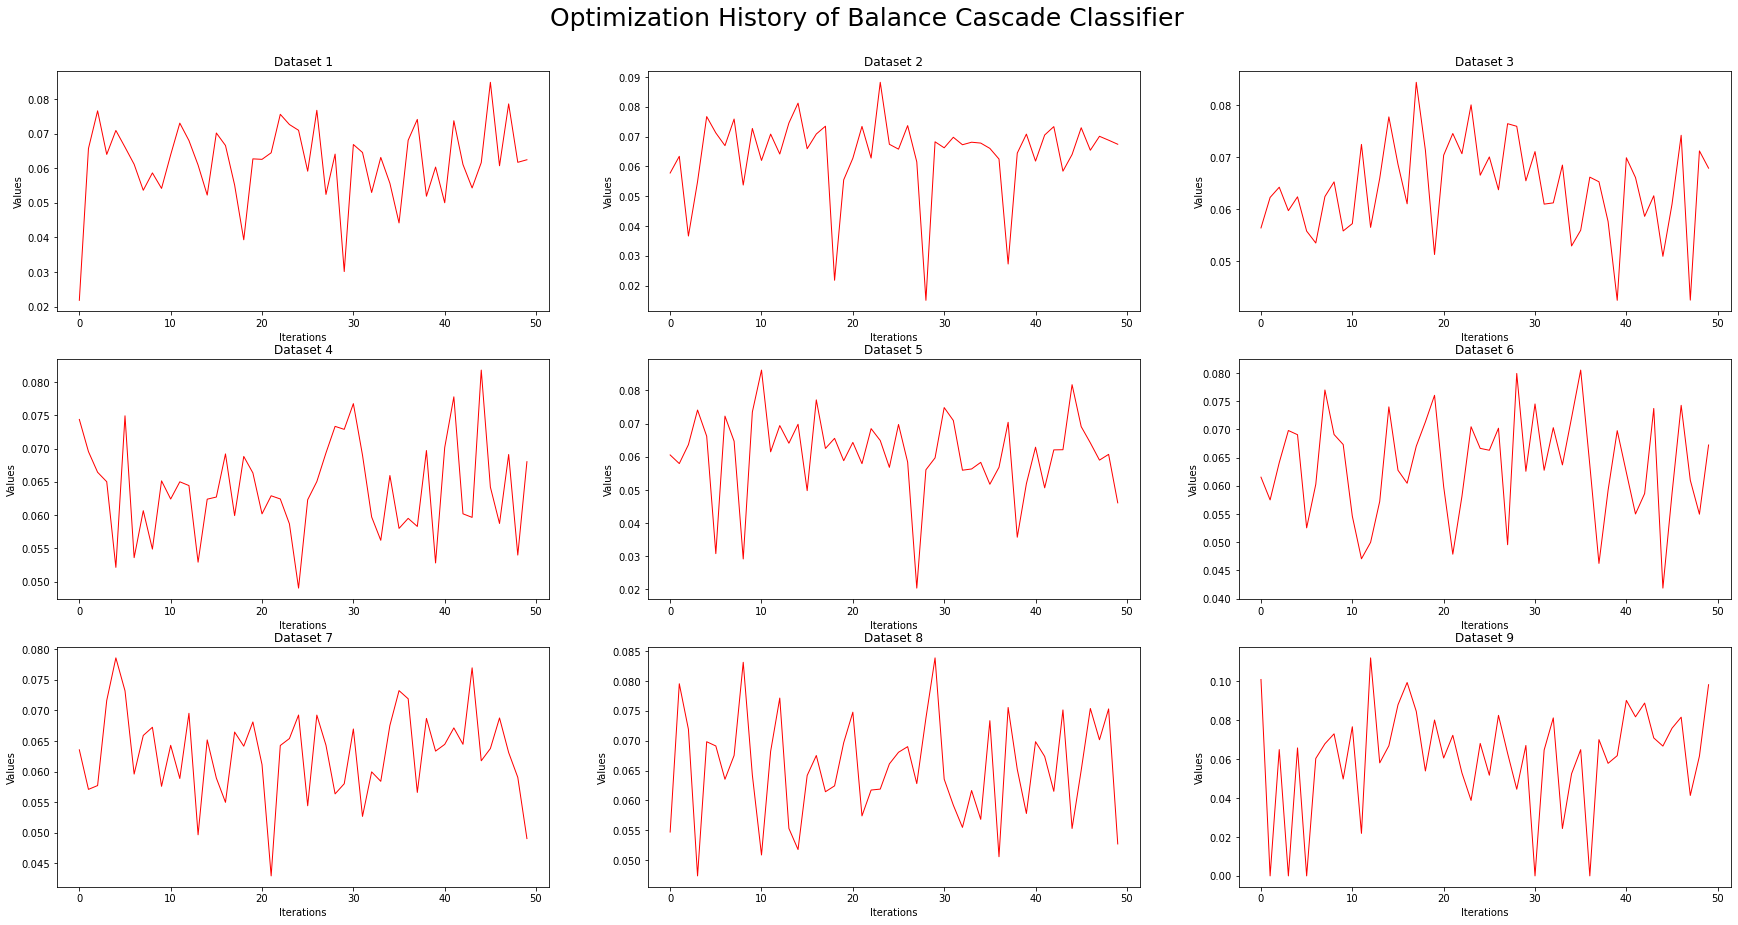

In [22]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 3, num_col = 3, model = 'Balance Cascade Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

### Classifier

#### Scheme 1


 Dataset 1:

Iteration 1:
Stop Oversampling !
Size after Undersampling: 3084

Iteration 2:
Stop Oversampling !
Size after Undersampling: 3084

Iteration 3:
Stop Oversampling !
Size after Undersampling: 3084

Iteration 4:
Stop Oversampling !
Size after Undersampling: 3084

Iteration 5:
Stop Oversampling !
Stop Undersampling !
Precision: 0.0016835016835016834 
Recall: 0.11764705882352941 
Aging Rate: 0.07325947090382125

 Dataset 2:

Iteration 1:
Stop Oversampling !
Size after Undersampling: 3018

Iteration 2:
Stop Oversampling !
Size after Undersampling: 3018

Iteration 3:
Stop Oversampling !
Size after Undersampling: 3018

Iteration 4:
Stop Oversampling !
Size after Undersampling: 3018

Iteration 5:
Stop Oversampling !
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.01050381302801702

 Dataset 3:

Iteration 1:
Stop Oversampling !
Size after Undersampling: 3032

Iteration 2:
Stop Oversampling !
Size after Undersampling: 3032

Iteration 3:
Stop Oversampling !
Size after Undersampling: 3032

Iteration 4:
Stop Oversampling !
Size after Undersampling: 3032

Iteration 5:
Stop Oversampling !
Stop Undersampling !
Precision: 0.0005224660397074191 
Recall: 0.0196078431372549 
Aging Rate: 0.03934304918908919

 Dataset 4:

Iteration 1:
Stop Oversampling !
Size after Undersampling: 3036

Iteration 2:
Stop Oversampling !
Size after Undersampling: 3036

Iteration 3:
Stop Oversampling !
Size after Undersampling: 3036

Iteration 4:
Stop Oversampling !
Size after Undersampling: 3036

Iteration 5:
Stop Oversampling !
Stop Undersampling !
Precision: 0.001628001628001628 
Recall: 0.0784313725490196 
Aging Rate: 0.050504635244301016

 Dataset 5:

Iteration 1:
Stop Oversampling !
Size after Undersampling: 3034

Iteration 2:
Sto

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0

 Dataset 9:

Iteration 1:
Stop Oversampling !
Size after Undersampling: 608

Iteration 2:
Stop Oversampling !
Size after Undersampling: 608

Iteration 3:
Stop Oversampling !
Size after Undersampling: 608

Iteration 4:
Stop Oversampling !
Size after Undersampling: 608

Iteration 5:
Stop Oversampling !
Stop Undersampling !
Precision: 0.0011337868480725624 
Recall: 0.19607843137254902 
Aging Rate: 0.18129869062056775


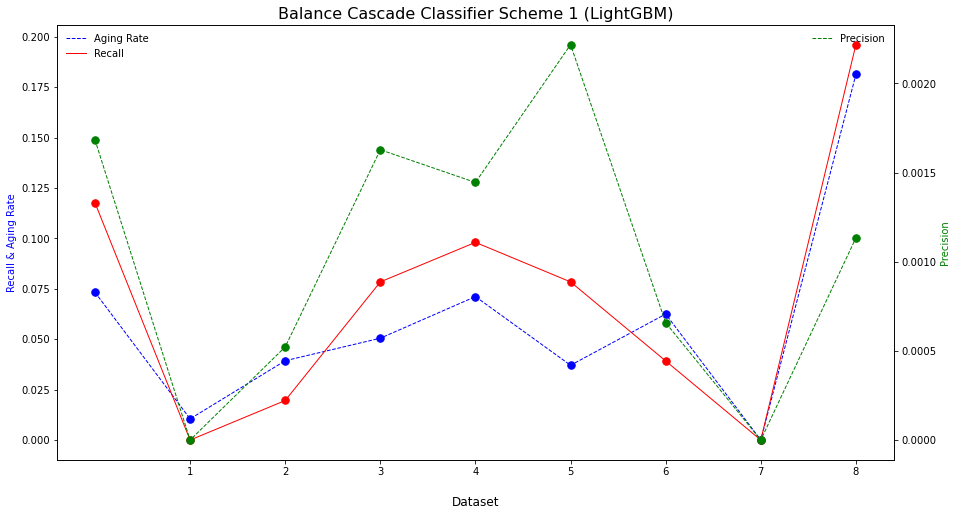

In [14]:
table_setC = runall_cascade(run_train, run_test, base_paramC, num_iter = 5)
line_chart(table_setC, title = 'Balance Cascade Classifier Scheme 1 (LightGBM)')

In [15]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,F1 Score,Score
dataset 1,25.00000,38550.0,1542.0,6.0,3558.0,45.0,45040.0,0.001684,0.117647,0.073259,1.605896,0.001660,0.112680
dataset 2,25.00000,37725.0,1509.0,0.0,511.0,51.0,48087.0,0.000000,0.000000,0.010504,0.000000,NaN,0.000000
dataset 3,25.00000,37900.0,1516.0,1.0,1913.0,50.0,46685.0,0.000522,0.019608,0.039343,0.498381,0.000509,0.000000
dataset 4,25.00000,37950.0,1518.0,4.0,2453.0,47.0,46145.0,0.001628,0.078431,0.050505,1.552954,0.001595,0.073510
dataset 5,25.04944,38000.0,1517.0,5.0,3456.0,46.0,45142.0,0.001445,0.098039,0.071142,1.378073,0.001424,0.084930
dataset 6,25.18224,38000.0,1509.0,4.0,1800.0,47.0,46798.0,0.002217,0.078431,0.037082,2.115082,0.002156,0.089118
dataset 7,25.18224,38000.0,1509.0,2.0,3038.0,49.0,45560.0,0.000658,0.039216,0.062488,0.627567,0.000647,0.000000
dataset 8,25.00000,38000.0,1520.0,0.0,0.0,51.0,48598.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
dataset 9,25.00000,7600.0,304.0,10.0,8810.0,41.0,39788.0,0.001134,0.196078,0.181299,1.081521,0.001127,0.143745


#### Scheme 2


 Dataset 1:

Iteration 1:
Size before Oversampling: 32382
Size after Oversampling: 38591
Size after Undersampling: 9252

Iteration 2:
Size before Oversampling: 27980
Size after Oversampling: 34127
Size after Undersampling: 9252

Iteration 3:
Size before Oversampling: 24206
Size after Oversampling: 30360
Size after Undersampling: 9252

Iteration 4:
Size before Oversampling: 20971
Size after Oversampling: 27134
Size after Undersampling: 9252

Iteration 5:
Size before Oversampling: 18198
Size after Oversampling: 24342
Size after Undersampling: 9252

Iteration 6:
Size before Oversampling: 15821
Size after Oversampling: 22005
Size after Undersampling: 9252

Iteration 7:
Size before Oversampling: 13783
Size after Oversampling: 19940
Size after Undersampling: 9252

Iteration 8:
Size before Oversampling: 12036
Size after Oversampling: 18187
Size after Undersampling: 9252

Iteration 9:
Size before Oversampling: 10538
Size after Oversampling: 16672
Size after Undersampling: 9252

Iteration 10:


Size after Oversampling: 38002
Size after Undersampling: 9120

Iteration 2:
Size before Oversampling: 27581
Size after Oversampling: 33652
Size after Undersampling: 9120

Iteration 3:
Size before Oversampling: 23861
Size after Oversampling: 29920
Size after Undersampling: 9120

Iteration 4:
Size before Oversampling: 20672
Size after Oversampling: 26739
Size after Undersampling: 9120

Iteration 5:
Size before Oversampling: 17938
Size after Oversampling: 24000
Size after Undersampling: 9120

Iteration 6:
Size before Oversampling: 15595
Size after Oversampling: 21693
Size after Undersampling: 9120

Iteration 7:
Size before Oversampling: 13586
Size after Oversampling: 19640
Size after Undersampling: 9120

Iteration 8:
Size before Oversampling: 11864
Size after Oversampling: 17914
Size after Undersampling: 9120

Iteration 9:
Size before Oversampling: 10388
Size after Oversampling: 16427
Size after Undersampling: 9120

Iteration 10:
Size before Oversampling: 9123
Size after Oversampling: 152

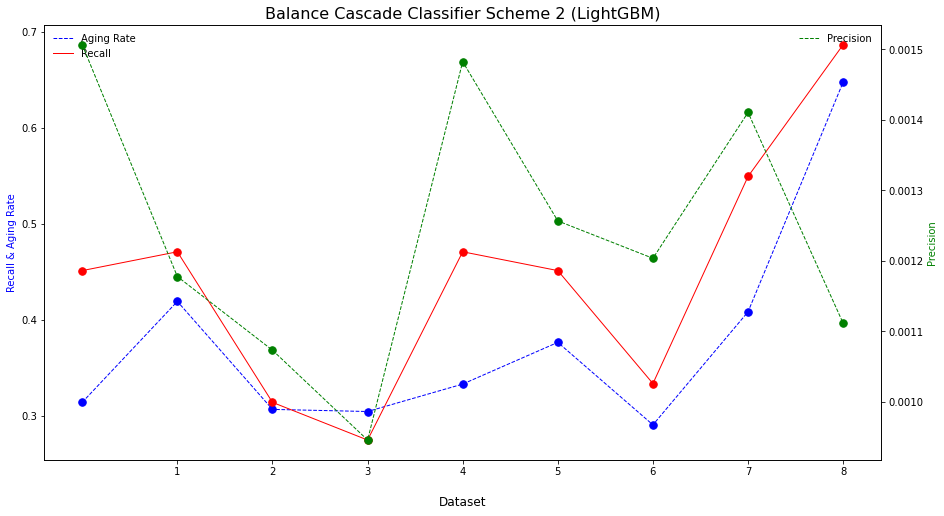

In [27]:
table_setC = runall_cascade(run_train, run_test, base_config = base_paramC, meta_config = meta_paramC)
line_chart(table_setC, title = 'Balance Cascade Classifier Scheme 2 (LightGBM)')

In [28]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,F1 Score,Score
dataset 1,20.000000,30840.0,1542.0,23.0,15244.0,28.0,33354.0,0.001507,0.450980,0.313819,1.437070,0.001502,0.401732
dataset 2,20.000000,30020.0,1501.0,24.0,20354.0,27.0,28244.0,0.001178,0.470588,0.418878,1.123449,0.001175,0.354373
dataset 3,20.000000,30320.0,1516.0,16.0,14891.0,35.0,33707.0,0.001073,0.313725,0.306419,1.023843,0.001070,0.221176
dataset 4,20.000000,30360.0,1518.0,14.0,14786.0,37.0,33812.0,0.000946,0.274510,0.304220,0.902340,0.000943,0.000000
dataset 5,20.253165,30400.0,1501.0,24.0,16166.0,27.0,32432.0,0.001482,0.470588,0.332792,1.414061,0.001478,0.414734
dataset 6,20.105820,30400.0,1512.0,23.0,18280.0,28.0,30318.0,0.001257,0.450980,0.376226,1.198697,0.001253,0.355312
dataset 7,20.172528,30400.0,1507.0,17.0,14107.0,34.0,34491.0,0.001204,0.333333,0.290325,1.148140,0.001199,0.254867
dataset 8,20.000000,30400.0,1520.0,28.0,19824.0,23.0,28774.0,0.001410,0.549020,0.408066,1.345419,0.001407,0.468019
dataset 9,20.000000,6080.0,304.0,35.0,31454.0,16.0,17144.0,0.001111,0.686275,0.647269,1.060261,0.001110,0.496062


### Export

In [15]:
savedate = '20220329'
TPE_multi = False
scheme = 2

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = f'BC_scheme{scheme}_iter5_over5'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = f'BC_scheme{scheme}_iter5_over5')